In [1]:
# notebook to pinpoint degradation, rapid fire some more ideas, using noun setting

In [1]:
import pickle
from encode_utils.rerank_data import rerank_dist, rerank_single
from encode_utils.efficient_rerank import get_effrerank_model, run_comstyle
from encode_utils.sco_funct import weightaddprob, default_scofunct
from encode_utils.mt_scores import get_scores_auto
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import torch
import random
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


2022-12-24 06:27:13.334574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-24 06:27:13.334596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
russian_explode = pd.read_csv("outputs/score_csvs/enruexplodev1.csv")

In [5]:
russian_fewsamp = pd.read_csv("outputs/score_csvs/enrufewsampv1.csv")

In [2]:
# get graph to examine
ind = 3
base = "outputs/graph_pickles/nounfull_exploded/"
#base = "outputs/graph_pickles/rutest_reversed/"
graph = pickle.load(open(base+str(ind), 'rb'))

In [4]:
# get exploded paths, scored, for the graph
noun_explode = pd.read_csv("outputs/score_csvs/frenbeam12v1.csv")

#noun_explode = pd.read_csv("outputs/score_csvs/nounexplodev1.csv")
#noun_explode = pd.read_csv("outputs/score_csvs/nounexplodev1.csv")
texplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
bestcand = np.argmax(list(texplode['utnoun']))
bestcand = texplode.iloc[bestcand]

In [22]:
# helper for exploding paths
def explode_helper(prevpath, node, apaths, tok):
    prevpath.append(node.token_idx)
    if len(node.nextlist)==0:
        apaths.append(tok.decode(prevpath))
    else:
        for n in node.nextlist:
            explode_helper(prevpath, n, apaths, tok)
    prevpath.pop()

In [26]:
pts = []
explode_helper([], flnodes[0], pts, xlm_tok)
pts = [p[4:] for p in pts]

In [32]:
bestcand['hyp']

'To understand the benefits of emigration, the case of Kallstadt, a small farmer’s town in southwestern Germany, is particularly telling. Friedrich (Fred) Trump – Donald Trump’s grandfather – was born there on 14 March 1869.'

In [7]:
bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
            flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, default_scofunct, "noun", {'afunc':randomsingle}, True)
predhyp = bestpath[0][4:]
print(predhyp)

To understand the benefits of emigration, the case of Kallstadt, a small-scale farmers’ town in southwestern Germany, is particularly telling. Friedrich (Fred) Trump – Donald Trump’s grandfather – was born there on March 14, 1869.


In [19]:
# recombination sanity check
torch.sum(mask!=torch.tril(mask))

tensor(0)

In [3]:
# load the model
encodemod = get_effrerank_model("noun")
xlm_tok = AutoTokenizer.from_pretrained("xlm-roberta-base")

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_44/checkpoints/epoch=9-step=40000.ckpt.


freeze embeds


In [6]:
def randomsingle(mask, row, checknodes, mlen):
    if row>0:
        avail = []
        # use next with highest prob
        for n in checknodes:
            if n.canvpos<mlen: # keep within bounds
                avail.append(n)
        if len(avail)==0:
            print(len(checknodes))
            print(row)
        mask[row][random.choice(avail).canvpos] = 1
        
def useall(mask, row, checknodes, mlen):
    if row>0:
        # use next with highest prob
        for n in checknodes:
            if n.canvpos<mlen: # keep within bounds
                mask[row][n.canvpos] = 1
        
# randomly use nodes, but possibility of more than one previous node being used
def randommulti(mask, row, checknodes, mlen):
    if row>0:
        avail = []
        # use next with highest prob
        for n in checknodes:
            if n.canvpos<mlen: # keep within bounds
                avail.append(n)
        if len(avail)==0:
            print(len(checknodes))
            print(row)
        #mask[row][random.choice(avail).canvpos] = 1
        
        tosamp = random.randint(1, len(avail))
        samp = random.sample(avail, tosamp)
        # use next with highest prob
        for n in samp:
            if n.canvpos<mlen: # keep within bounds
                mask[row][n.canvpos] = 1 

In [16]:
# score check (at token level) the best option, and the new option (should be same until they get to non-identical tokens)

SETLEN = 457

# get token level scores from model
def get_hyp_sco(inphyp, posids=None):
    
    tokens = xlm_tok(inphyp, return_tensors='pt').to(device)
    tokens = tokens.input_ids
    if posids is None: 
        positionids = None
    else:
        # get token at the end
        positionids = torch.tensor(posids+[posids[-1]+1]).unsqueeze(0).to(device)
    tmpmask = torch.tril(torch.ones(len(tokens[0]), len(tokens[0]))).unsqueeze(0).to(device)

    toked_inp = xlm_tok(["noun"], return_tensors="pt").to(device)
    predout = encodemod(toked_inp.input_ids, toked_inp.attention_mask, tokens, positionids, \
        tmpmask)
    tmppred = predout['score']
    #norm = predout['norm']
    return tmppred

# test out reranking multiple EEL outputs (observe improvements)
def lattice_multi_rerank(ind, n):
    # get graph, get the "best candidate"
    graph = pickle.load(open(base+str(ind), 'rb'))
    nexplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
    #print(len(nexplode))
    if len(nexplode)==0:
        return None
    bestcand = np.argmax(list(nexplode['utnoun']))
    bestcand = nexplode.iloc[bestcand]
    
    goldsco = get_hyp_sco(bestcand['hyp'])
    goldsco = torch.sum(goldsco[0])
    bpred = -100
    bhyp = ""
    ascos = []
    ahyps = []
    numnodes = 0
    for i in range(n):
        graph = pickle.load(open(base+str(ind), 'rb'))
        # generate with model
        bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
            flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, default_scofunct, "noun", {'afunc':useall}, True)
        predhyp = bestpath[0][4:]
        hypsco = torch.sum(get_hyp_sco(predhyp)[0])
        if hypsco>bpred:
            bpred = hypsco
            bhyp = predhyp
        ascos.append(hypsco)
        ahyps.append(predhyp)
        numnodes = len(flattened)
    return bpred, bhyp, goldsco, bestcand['hyp'], ascos, ahyps, numnodes

# get multiple things with the lattice, rerank on each (not optimized, so it is a bit slow)
def all_lattice_multi(n):
    pdistr = []
    cnt = 0
    for i in range(SETLEN):
        try:
            outval = lattice_multi_rerank(i, n)
        except:
            print("had an error")
        if outval==None:
            continue
        else:
            print(cnt, " ", i, " ", outval[0], " ", outval[2], " ")
            pdistr.append({
                'hyp':outval[1],
                'hypsco':outval[0],
                'gold':outval[3],
                'goldsco':outval[2],
                'ascos':[float(f) for f in outval[4]],
                'ahyps':outval[5],
                'numnodes':outval[6]
            })
            cnt+=1
    res = pd.DataFrame(pdistr)
    return res

# rerank given a random sample
def all_unnoun_multi():
    pdistr = []
    cnt = 0
    for i in range(SETLEN):
        try:
            graph = pickle.load(open(base+str(i), 'rb'))
        except:
            break
        nexplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
        if len(nexplode)==0:
            continue
        nexplode = nexplode.sample(n=32)
        assert len(nexplode)==32
        bestcand = np.argmax(list(nexplode['utnoun']))
        bestcand = nexplode.iloc[bestcand]

        goldsco = get_hyp_sco(bestcand['hyp'])
        goldsco = torch.sum(goldsco[0])
        pdistr.append(goldsco)
    
    return pdistr

In [31]:
unnoun = all_unnoun_multi()

In [18]:
lattice_multi_rerank(3, 1)

(tensor(1.5102, device='cuda:0', grad_fn=<SumBackward0>),
 'To understand the benefits of emigration, the case of Kallstadt, a small-scale farmers’ town in southwestern Germany, is particularly telling. Friedrich (Fred) Trump – Donald Trump’s grandfather – was born there on March 14, 1869.',
 tensor(1.5723, device='cuda:0', grad_fn=<SumBackward0>),
 'To understand the benefits of emigration, the case of Kallstadt, a small farmer’s town in southwestern Germany, is particularly telling. Friedrich (Fred) Trump – Donald Trump’s grandfather – was born there on 14 March 1869.',
 [tensor(1.5102, device='cuda:0', grad_fn=<SumBackward0>)],
 ['To understand the benefits of emigration, the case of Kallstadt, a small-scale farmers’ town in southwestern Germany, is particularly telling. Friedrich (Fred) Trump – Donald Trump’s grandfather – was born there on March 14, 1869.'],
 399)

In [33]:
sum(unnoun)/len(unnoun)

tensor(0.9343, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
allmulti = all_lattice_multi(32)

In [9]:
allmulti.to_csv("outputs/predcsvs/noun_comstyle_multi_32.csv")

In [10]:
len(allmulti)

99

In [41]:
#allmulti = pd.read_csv("outputs/predcsvs/noun_comstyle_multi_32.csv")

In [46]:
oldamult = allmulti

In [66]:
# gold values are the same...
for i in range(len(allmulti)):
    if allmulti['gold'].iloc[i] not in oldamult['gold'].iloc[i]:
        print("bad")

In [ ]:
list(zip(list(allmulti['goldsco']), list(oldamult['goldsco'])))

In [11]:
import re
def mean(l):
    l = list(l)
    if type(l[0]) is str:
        l = [float(re.findall("\d+\.\d+", lent)[0]) for lent in l]
    return sum(l)/len(l)

print(mean(allmulti['goldsco']))
print(mean(allmulti['hypsco']))
print(mean(allmulti['goldsco'])-mean(allmulti['hypsco']))

tensor(0.9787, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9597, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0190, device='cuda:0', grad_fn=<SubBackward0>)


In [41]:
allmulti['unoun'] = [float(f) for f in unnoun]

In [31]:
allmulti['hypsco']  = [float(re.findall("\d+\.\d+", lent)[0]) for lent in allmulti['hypsco']]

In [32]:
allmulti['goldsco']  = [float(re.findall("\d+\.\d+", lent)[0]) for lent in allmulti['goldsco']]

In [13]:
import matplotlib.pyplot as plt

(array([ 1.,  2.,  2.,  5., 67.,  7., 10.,  3.,  1.,  1.]),
 array([-0.18148696, -0.13931837, -0.09714978, -0.05498118, -0.01281259,
         0.029356  ,  0.0715246 ,  0.11369319,  0.15586178,  0.19803038,
         0.24019897]),
 <BarContainer object of 10 artists>)

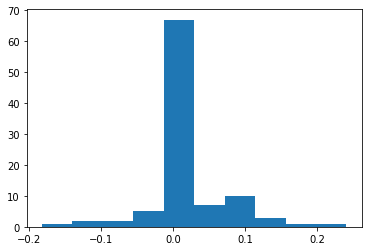

In [14]:
plt.hist([float(f) for f in list(allmulti['goldsco']-allmulti['hypsco'])])

In [85]:
len(allmulti[allmulti['numnodes']>512])

35

In [74]:
allmulti[allmulti['goldsco']-allmulti['hypsco']>.2]['gold'].iloc[6]

'At a time when all nations are facing their own challenges, there is a need to forge a common agenda at the global level that will ensure that the seven billionth baby and future generations grow up in a world of peace, prosperity, freedom and justice that lasts.'

In [24]:
mean(allmulti['hypsco'])

tensor(0.8882, device='cuda:0', grad_fn=<DivBackward0>)

In [19]:
ind = 3
# get model output
graph = pickle.load(open(base+str(ind), 'rb'))
sco_funct = default_scofunct
bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
        flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, sco_funct, "noun", {'afunc':randomsingle}, True)
predhyp = bestpath[0][4:]
print("generated - \n"+predhyp)

generated - 
To understand the benefits of emigration, the case of Kallstadt, a small-scale farmers’ town in southwestern Germany, is particularly telling. Friedrich (Fred) Trump – Donald Trump’s grandfather – was born there on March 14, 1869.


In [34]:
bestsco = get_hyp_sco(bestcand['hyp'])
hypsco = get_hyp_sco(predhyp)
print(bestcand['hyp'])
print(torch.sum(bestsco[0]))
print(predhyp)
print(torch.sum(hypsco[0]))
print(bsco)

NameError: name 'predhyp' is not defined

In [21]:
# test out reranking multiple EEL outputs (observe improvements)
def debug_multi_rerank(ind):
    # get graph, get the "best candidate"
    graph = pickle.load(open(base+str(ind), 'rb'))
    nexplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
    print(len(nexplode))
    if len(nexplode)==0:
        return None
    bestcand = np.argmax(list(nexplode['utnoun']))
    bestcand = nexplode.iloc[bestcand]
    
    goldsco = get_hyp_sco(bestcand['hyp'])
    goldsco = torch.sum(goldsco[0])
    bpred = -100
    bhyp = ""
    ascos = []
    ahyps = []
    numnodes = 0
    
    graph = pickle.load(open(base+str(ind), 'rb'))
    # generate with model
    bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
        flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, default_scofunct, "noun", {'afunc':useall}, True)
    predhyp = bestpath[0][4:]
    hypsco = torch.sum(get_hyp_sco(predhyp)[0])
    
    numnodes = len(flattened)
    return bpred, bhyp, goldsco, bestcand['hyp'], ascos, ahyps, numnodes


In [32]:
graph['root'].nextlist[0].prevs

[]

In [36]:
graph['root'].nextlist[0].token_str

'en_XX'

In [72]:
graph = pickle.load(open(base+str(3), 'rb'))

In [28]:
graph['root'].nextlist

In [37]:
mb_tok = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")

In [73]:
# recursive method to sanity check first (assume no recomb, no cycles)
def explode_path(ind):
    graph = pickle.load(open(base+str(ind), 'rb'))
    allpaths = []
    explode_helper([], graph['root'], allpaths, mb_tok)
    allpaths = [a[10:] for a in allpaths]
    nexplode = noun_explode[noun_explode['ref']==graph['ref']].reset_index()
    return allpaths, list(nexplode['hyp'])

# helper for exploding paths
def explode_helper(prevpath, node, apaths, tok):
    prevpath.append(node.token_idx)
    if len(node.nextlist)==0:
        #print(prevpath)
        apaths.append(mb_tok.decode(prevpath))
    else:
        for n in node.nextlist:
            explode_helper(prevpath, n, apaths, tok)
    prevpath.pop()

In [ ]:
bestpath , flattened, pnodes, mask, sents, posids, pred, _, \
        flnodes, dpath, beplist, besclist, totnodes, bsco = run_comstyle(graph, encodemod, default_scofunct, "noun", {'afunc':useall}, True)

In [74]:
apths = []
explode_helper([], pnodes[0][0], apths, xlm_tok)

In [76]:
len(apths)

300

In [57]:
# lattice reversal is ok 
for p in postrev:
    assert p in prerev

In [ ]:
# have some doubts about explosion algorithm, check if outputs are the same
def new_explode_paths(ind):
    graph = pickle.load(open(base+str(ind), 'rb'))
    queue = []
    visited = []
    # start from root
    queue.append(([], graph['root']))
    while len(queue)>0:
        # always append token to end
        prevtoks, curnode = queue.pop()
        # avoid cycles
        if curnode in visited:
            mb_tok
        
        

In [22]:
debug_multi_rerank(3)

12


(-100,
 '',
 tensor(1.5723, device='cuda:0', grad_fn=<SumBackward0>),
 'To understand the benefits of emigration, the case of Kallstadt, a small farmer’s town in southwestern Germany, is particularly telling. Friedrich (Fred) Trump – Donald Trump’s grandfather – was born there on 14 March 1869.',
 [],
 [],
 399)

In [33]:
# sanity check that masks are functioning in an ok way (passed)
def mask_sanity(msk, inps, posids):
    allinps = []
    allpos = []
    for m in msk:
        # get spare
        tmptoks = []
        tmppos = []
        for t in range(len(m)):
            if m[t]!=0:
                tmptoks.append(inps[t])
                tmppos.append(posids[t])
        resort = sorted(zip(tmppos, tmptoks))
        tmptoks = [x for _,x in resort]
        tmppos = [x for x, _ in resort]
        allinps.append(torch.tensor(tmptoks).int())
        allpos.append(tmppos)
    return allinps, allpos

In [78]:
a = [1, 2]
b = ['a', 'b']
c = zip(a, b)

In [79]:
list(c)

[(1, 'a'), (2, 'b')]

In [46]:
# score check (at token level) the best option, and the new option (should be same until they get to non-identical tokens)

# get token level scores from model
def get_hyp_sco_verb(inphyp, posids=None):
    
    tokens = xlm_tok(inphyp, return_tensors='pt').to(device)
    tokens = tokens.input_ids
    #print(inphyp)
    #print(tokens)
    
    if posids is None: 
        positionids = torch.arange(len(tokens[0])).unsqueeze(0).to(device)+2
        print(positionids)
        #mask = tokens.ne(-1).int()
        #incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + 0) * mask
        #positionids = incremental_indices.long() + 1
    elif -1 in posids:
        positionids = None
    else:
        # get token at the end
        positionids = torch.tensor(posids+[posids[-1]+1]).unsqueeze(0).to(device)
        print(positionids)
    #print(positionids)
    tmpmask = torch.tril(torch.ones(len(tokens[0]), len(tokens[0]))).unsqueeze(0).to(device)
    #print(tokens.shape)
    #print(positionids.shape)
    #print()
    #print(tokens.shape)
    #print(torch.max(positionids))
    toked_inp = xlm_tok(["noun"], return_tensors="pt").to(device)
    predout = encodemod(toked_inp.input_ids, toked_inp.attention_mask, tokens, positionids, \
        tmpmask)
    tmppred = predout['score']
    #norm = predout['norm']
    return tmppred, tokens, positionids, tmpmask

In [37]:
mask = mask.to("cuda:0")

In [38]:
ainps, apos = mask_sanity(mask, sents[0], posids[0])

KeyboardInterrupt: 

In [40]:
testsens = xlm_tok.batch_decode(ainps)

In [47]:
index = 50
#print(apos[index])
p_pred, p_tok, p_pos, p_mask = get_hyp_sco_verb(testsens[index][4:], None)
n_pred, n_tok, n_pos, n_mask = get_hyp_sco_verb(testsens[index][4:], apos[index])

tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]],
       device='cuda:0')
tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 33, 34, 35, 36]],
       device='cuda:0')


In [48]:
list(zip([float(f) for f in p_pred[0]], [float(f) for f in n_pred[0]]))

[(0.0, 0.0),
 (0.0008179583819583058, 0.0008406794513575733),
 (0.0008266505901701748, 0.0008496131049469113),
 (0.0008246707147918642, 0.0008475782815366983),
 (0.0008184637990780175, 0.000841198896523565),
 (0.0015539380256086588, 0.001597102964296937),
 (0.0008968535694293678, 0.0009217661572620273),
 (0.0009072879911400378, 0.0009324904531240463),
 (0.001034791232086718, 0.0010635354556143284),
 (0.02084461599588394, 0.02142363227903843),
 (0.00419287895783782, 0.004309347830712795),
 (0.004512493032962084, 0.004637839738279581),
 (0.035868171602487564, 0.0368645079433918),
 (0.005156939383596182, 0.005300187971442938),
 (0.04388004168868065, 0.0450989305973053),
 (0.008241300471127033, 0.00847022607922554),
 (0.05495584383606911, 0.05648239329457283),
 (0.01089283637702465, 0.011195415630936623),
 (0.00667963782325387, 0.0068651833571493626),
 (0.023293253034353256, 0.02394028753042221),
 (0.015207698568701744, 0.01563013345003128),
 (0.03848055750131607, 0.039549462497234344),
 (

In [22]:
pred1, tok1, pos1, mask1 = get_hyp_sco_verb("I am nice")
pred2, tok2, pos2, mask2 = get_hyp_sco_verb("I am cool")


here
here


In [24]:
print(pred1)
print(pred2)

tensor([[[0.0000],
         [0.0074],
         [0.0029],
         [0.0081],
         [0.0036]]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[[0.0000],
         [0.0074],
         [0.0029],
         [0.0080],
         [0.0054]]], device='cuda:0', grad_fn=<DivBackward0>)


In [26]:
fpos = []
for pl in apos:
    tmp = []
    for p in pl:
        tmp.append(int(p))
    fpos.append(tmp)

In [ ]:
# pos ids as a source of degradation?
for i in range(1, len(fpos)):
    for j in range(1, len(fpos[i])):
        if fpos[i][j] is not fpos[i][j-1]+1:
            print("off at ", i, " ", fpos[i][j-1], " ",fpos[i][j] )

In [ ]:
fpos[40:]

In [21]:
def test_graph_ind(base, ind, model, funct, outfile):
    graph = pickle.load(open(base+str(ind), 'rb'))
    return {
        'hyp':run_comstyle(graph, model, funct, outfile, False)[0],
        'ref':graph['ref'],
        'src':graph['input']
    }

In [ ]:
import pandas as pd
from encode_utils.rerank_data import rerank_dist, rerank_single
from encode_utils.mt_scores import get_scores_auto
from encode_utils.sco_funct import weightaddprob, default_scofunct

from test_efficient_rerank import test_graph_ind

In [3]:
def mean(l):
    return sum(l)/len(l)

In [3]:
noun_explode = pd.read_csv("outputs/score_csvs/nounexplodev1.csv")

In [6]:
gold_vals = rerank_dist(noun_explode, rerank_single, ['utnoun', 'utnoun'])

In [40]:
# get model 


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.
Loading weights from /mnt/data1/prasann/latticegen/lattice-generation/COMET/lightning_logs/version_44/checkpoints/epoch=9-step=40000.ckpt.


In [45]:
res = test_graph_ind("outputs/graph_pickles/frtest_reversed/", 0, encodemod, default_scofunct, "noun")

In [46]:
res

{'hyp': '<s> After all, as a field investigative journalist, she has instilled in many people besides Putin, including the current Chechen Prime Minister Ramzan Kadyrov, not the least of whom she has accused of conducting a policy of abduction for ransom.',
 'ref': 'After all, as a campaigning investigative journalist she made many people angry besides Putin, not least of which is the current Chechen Prime Minister, Ramzan Kadyrov, whom she accused of a policy of kidnapping for ransom. ',
 'src': "Après tout, en tant que journaliste d'investigation en campagne, elle a enragé beaucoup d'autres gens outre Poutine, parmi lesquels l'actuel Premier ministre tchétchène Ramzan Kadyrov n'est pas des moindres, qu'elle a accusé de mener une politique d'enlèvements contre rançons. "}

In [ ]:
get_scores_auto([res['hyp'][4:]], ["noun"], [], "utnoun", "comstyle")

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
npreds = pd.read_csv("outputs/predcsvs/noun_comstyle_v2.csv")

In [21]:
uns = list(noun_explode['ref'].unique())

In [49]:
res = []
for u in uns: 
    res.append(float(npreds[npreds['ref']==u]['utnoun']))

In [50]:
mean(res)

0.8628873924911022

In [56]:
diffs = [gold_vals[i] - res[i] for i in range(len(res))]

In [58]:
mean(diffs)

0.08779214024543762

In [59]:
import matplotlib.pyplot as plt

(array([ 1.,  1.,  1., 21., 17., 32., 15.,  8.,  3.,  1.]),
 array([-0.16788018, -0.11897451, -0.07006885, -0.02116318,  0.02774248,
         0.07664815,  0.12555381,  0.17445948,  0.22336514,  0.2722708 ,
         0.32117647]),
 <BarContainer object of 10 artists>)

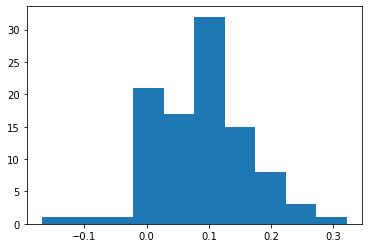

In [60]:
plt.hist(diffs)

In [62]:
for i in range(len(diffs)):
    if diffs[i]<0:
        print(i)

13
24
29
30
75


In [75]:
hyp = npreds[npreds['ref']==uns[13]]['ahyp'].iloc[0]

In [79]:
noun_explode[noun_explode['ref']==uns[13]]

,Unnamed: 0,src,ref,hyp,utnoun,unique_nouns
27070,27070,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards much mo...,0.393927,5
27071,27071,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path to much more re...,0.383695,4
27072,27072,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path to a much more ...,0.398260,4
27073,27073,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards a much ...,0.409214,4
27074,27074,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards far mor...,0.390841,5
...,...,...,...,...,...,...
28342,28342,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards far mor...,0.621482,8
28343,28343,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path toward much mor...,0.623692,7
28344,28344,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path to far more res...,0.606072,7
28345,28345,En l’absence d'une voie claire vers une union ...,Absent a clear path to a much tighter fiscal a...,In the absence of a clear path towards much mo...,0.623454,8


In [80]:
hyp

'In the absence of a clear path towards a much more restrictive financial and political union, which can only be achieved by means of a constitutional change, the euro system’s current “transition house" of the euro system looks increasingly unsustainable.'

In [6]:
l = torch.arange(10, dtype=torch.long).view(-1, 1)
r = torch.arange(10, dtype=torch.long).view(1, -1)

In [9]:
(l - r)+512-1

tensor([[511, 510, 509, 508, 507, 506, 505, 504, 503, 502],
        [512, 511, 510, 509, 508, 507, 506, 505, 504, 503],
        [513, 512, 511, 510, 509, 508, 507, 506, 505, 504],
        [514, 513, 512, 511, 510, 509, 508, 507, 506, 505],
        [515, 514, 513, 512, 511, 510, 509, 508, 507, 506],
        [516, 515, 514, 513, 512, 511, 510, 509, 508, 507],
        [517, 516, 515, 514, 513, 512, 511, 510, 509, 508],
        [518, 517, 516, 515, 514, 513, 512, 511, 510, 509],
        [519, 518, 517, 516, 515, 514, 513, 512, 511, 510],
        [520, 519, 518, 517, 516, 515, 514, 513, 512, 511]])